In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
FOLDER = '../../data_handson/champs-scalar-coupling/'
os.listdir(FOLDER)

['scalar_coupling_contributions.csv',
 'mulliken_charges.csv',
 'structures.csv',
 'test.csv',
 'structures.zip',
 'train.csv',
 'magnetic_shielding_tensors.csv',
 'dipole_moments.csv',
 'sample_submission.csv',
 'potential_energy.csv']

## load all files as pandas dataframe

In [3]:
# df_mulliken_charges = pd.read_csv(FOLDER + 'mulliken_charges.csv')
# df_sample =  pd.read_csv(FOLDER + 'sample_submission.csv')
# df_magnetic_shielding_tensors = pd.read_csv(FOLDER + 'magnetic_shielding_tensors.csv')
df_train = pd.read_csv(FOLDER + 'train.csv')
# df_test = pd.read_csv(FOLDER + 'test.csv')
# df_dipole_moments = pd.read_csv(FOLDER + 'dipole_moments.csv')
# df_potential_energy = pd.read_csv(FOLDER + 'potential_energy.csv')
df_structures = pd.read_csv(FOLDER + 'structures.csv')
# df_scalar_coupling_contributions = pd.read_csv(FOLDER + 'scalar_coupling_contributions.csv')

In [5]:
df_structures_idx = df_structures.set_index('molecule_name')

In [6]:
df_structures_idx.loc['dsgdb9nsd_000001']

,atom_index,atom,x,y,z
molecule_name,,,,,
dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [8]:
atoms = ['H', 'C', 'N', 'O', 'F']

In [78]:
def get_dir_matrix(df_structures_idx, molecule):
    df_temp = df_structures_idx.loc[molecule]
    locs = df_temp[['x','y','z']].values
    num_atoms = len(locs)
    loc_tile = np.tile(locs.T, (num_atoms,1,1))
    dist_mat = (loc_tile - loc_tile.T)
    return dist_mat # [atom0, (x,y,z), atom1]

In [164]:
def get_dist_matrix(df_structures_idx, molecule):
    df_temp = df_structures_idx.loc[molecule]
    locs = df_temp[['x','y','z']].values
    num_atoms = len(locs)
    loc_tile = np.tile(locs.T, (num_atoms,1,1))
    dist_mat = np.linalg.norm(loc_tile - loc_tile.T, axis=1)
    return dist_mat

In [461]:
def n_cos(df_structures_idx, mol, thres=1.65):
    dist_mat = get_dist_matrix(df_structures_idx, mol)
    df_temp = df_structures_idx.loc[mol]
    num_atoms = df_temp.shape[0]
    n_idx = df_temp[df_temp['atom'] == 'N']['atom_index'].values
    n_cos2 = []
    n_cos3 = []    

    for i in n_idx:
        dist_argsort = np.argsort(dist_mat[i])
        near_1_idx = dist_argsort[1]
        near_2_idx = dist_argsort[2]
        
        dist_1 = dist_mat[i][near_1_idx]
        dist_2 = dist_mat[i][near_2_idx]
        
        if dist_2 > thres:
            n_cos2.append(-1)
            n_cos3.append(2)
            continue
        else:
            origin_loc = df_temp[df_temp['atom_index'] == i][['x', 'y', 'z']].values[0]
            near_1_loc = df_temp[df_temp['atom_index'] == near_1_idx][['x', 'y', 'z']].values[0]
            near_2_loc = df_temp[df_temp['atom_index'] == near_2_idx][['x', 'y', 'z']].values[0]
            vec_01 = near_1_loc - origin_loc
            vec_02 = near_2_loc - origin_loc
            cos_12 = np.dot(vec_01, vec_02) / dist_1 / dist_2
            n_cos2.append(cos_12)
            try:
                near_3_idx = dist_argsort[3]
                near_3_loc = df_temp[df_temp['atom_index'] == near_3_idx][['x', 'y', 'z']].values[0]
                vec_03 = near_3_loc - origin_loc

                if  dist_mat[i][near_3_idx] < thres:
                    vec_012 = vec_01 / dist_1 + vec_02/ dist_2
                    cos_123 = np.dot(vec_012, vec_03) / np.linalg.norm(vec_012) /dist_mat[i][near_3_idx]
                    n_cos3.append(cos_123)
                else:
                    n_cos3.append(2)
            except:
                 n_cos3.append(2)

    se_n_cos2 = pd.Series(n_cos2, name='cos2')
    se_n_cos3 = pd.Series(n_cos3, name='cos3')
    
    se_n_idx = pd.Series(n_idx, name='atom_index')
    df_bond = pd.concat([se_n_idx, se_n_cos2, se_n_cos3], axis=1)

    df_temp2 = pd.merge(df_temp[['atom', 'atom_index']], df_bond, on='atom_index', how='outer').fillna(0)
    df_temp2['molecule_name'] = mol
    return df_temp2

In [462]:
n_cos(df_structures_idx, mol, 1.6)

,atom,atom_index,cos2,cos3,molecule_name
0,C,0,0.000000,0.000000,dsgdb9nsd_010290
1,O,1,0.000000,0.000000,dsgdb9nsd_010290
2,C,2,0.000000,0.000000,dsgdb9nsd_010290
3,C,3,0.000000,0.000000,dsgdb9nsd_010290
4,N,4,-1.000000,2.000000,dsgdb9nsd_010290
5,C,5,0.000000,0.000000,dsgdb9nsd_010290
6,N,6,-0.504613,-0.992237,dsgdb9nsd_010290
7,O,7,0.000000,0.000000,dsgdb9nsd_010290
8,H,8,0.000000,0.000000,dsgdb9nsd_010290
9,H,9,0.000000,0.000000,dsgdb9nsd_010290


In [463]:
def c_cos(df_structures_idx, mol, thres=1.65):
    dist_mat = get_dist_matrix(df_structures_idx, mol)
    df_temp = df_structures_idx.loc[mol]
    num_atoms = df_temp.shape[0]

    c_idx = df_temp[df_temp['atom'] == 'C']['atom_index'].values

    c_cos2 = []
    c_cos3 = []

    for i in c_idx:
        dist_argsort = np.argsort(dist_mat[i])

        near_1_idx = dist_argsort[1]
        near_2_idx = dist_argsort[2]

        origin_loc = df_temp[df_temp['atom_index'] == i][['x', 'y', 'z']].values[0]
        near_1_loc = df_temp[df_temp['atom_index'] == near_1_idx][['x', 'y', 'z']].values[0]
        near_2_loc = df_temp[df_temp['atom_index'] == near_2_idx][['x', 'y', 'z']].values[0]

        vec_01 = near_1_loc - origin_loc
        vec_02 = near_2_loc - origin_loc
        
        cos_12 = np.dot(vec_01, vec_02) / dist_mat[i][near_1_idx] / dist_mat[i][near_2_idx] 
        
        c_cos2.append(cos_12)

        try:
            near_3_idx = dist_argsort[3]
            near_3_loc = df_temp[df_temp['atom_index'] == near_3_idx][['x', 'y', 'z']].values[0]
            vec_03 = near_3_loc - origin_loc
            
            if  dist_mat[i][near_3_idx] < thres:
                vec_012 = vec_01 / dist_mat[i][near_1_idx] + vec_02/ dist_mat[i][near_2_idx]
                cos_123 = np.dot(vec_012, vec_03) / np.linalg.norm(vec_012) /dist_mat[i][near_3_idx]
                c_cos3.append(cos_123)
            else:
                c_cos3.append(2)
        except:
             c_cos3.append(2)
            
    se_c_cos2 = pd.Series(c_cos2, name='cos2')
    se_c_cos3 = pd.Series(c_cos3, name='cos3')
    
    se_c_idx = pd.Series(c_idx, name='atom_index')
    df_bond = pd.concat([se_c_idx, se_c_cos2, se_c_cos3], axis=1)

    df_temp2 = pd.merge(df_temp[['atom', 'atom_index']], df_bond, on='atom_index', how='outer').fillna(2)
    df_temp2['molecule_name'] = mol
    return df_temp2

In [464]:
c_cos(df_structures_idx, mol)

,atom,atom_index,cos2,cos3,molecule_name
0,C,0,-0.329899,-0.565950,dsgdb9nsd_010290
1,O,1,2.000000,2.000000,dsgdb9nsd_010290
2,C,2,-0.372732,-0.555976,dsgdb9nsd_010290
3,C,3,-0.999919,2.000000,dsgdb9nsd_010290
4,N,4,2.000000,2.000000,dsgdb9nsd_010290
5,C,5,-0.589275,-0.997550,dsgdb9nsd_010290
6,N,6,2.000000,2.000000,dsgdb9nsd_010290
7,O,7,2.000000,2.000000,dsgdb9nsd_010290
8,H,8,2.000000,2.000000,dsgdb9nsd_010290
9,H,9,2.000000,2.000000,dsgdb9nsd_010290


In [479]:
def get_cos(df_structures_idx, mol, thres=1.7):
    c_cos_temp = c_cos(df_structures_idx, mol, thres)[['cos2', 'cos3']].values
    n_cos_temp = n_cos(df_structures_idx, mol, thres)[['cos2', 'cos3']].values
    cos_mat = c_cos_temp + n_cos_temp
    out = np.where(cos_mat == 4, 2, cos_mat)
    return out

In [480]:
get_cos(df_structures_idx, mol, thres=1.7)

array([[-0.32989899, -0.56594985],
       [ 2.        ,  2.        ],
       [-0.37273163, -0.55597606],
       [-0.99991875,  2.        ],
       [ 1.        ,  2.        ],
       [-0.58927455, -0.99754991],
       [ 1.49538678,  1.00776325],
       [ 2.        ,  2.        ],
       [ 2.        ,  2.        ],
       [ 2.        ,  2.        ],
       [ 2.        ,  2.        ],
       [ 2.        ,  2.        ],
       [ 2.        ,  2.        ],
       [ 2.        ,  2.        ]])

In [477]:
test = get_cos(df_structures_idx, mol, thres=1.7)
test2 = np.where(test == 4, 2, test)

In [478]:
test2

array([[-0.32989899, -0.56594985],
       [ 2.        ,  2.        ],
       [-0.37273163, -0.55597606],
       [-0.99991875,  2.        ],
       [ 1.        ,  2.        ],
       [-0.58927455, -0.99754991],
       [ 1.49538678,  1.00776325],
       [ 2.        ,  2.        ],
       [ 2.        ,  2.        ],
       [ 2.        ,  2.        ],
       [ 2.        ,  2.        ],
       [ 2.        ,  2.        ],
       [ 2.        ,  2.        ],
       [ 2.        ,  2.        ]])

In [140]:
loc_c =  np.array([-0.012698, 1.085804, 0.008001])
loc_h1 = np.array([0.002150, -0.006031, 0.001976])
loc_h1 - loc_c

array([ 0.014848, -1.091835, -0.006025])

In [165]:
mols = df_structures['molecule_name'].unique()

In [327]:
num_sample = 2000

dir_h = np.zeros([0,3])
for mol in mols[:num_sample]:
    locs = get_dir_matrix(df_structures_idx, mol) # [atom, (x,y,z), (atom)]
    mask_c = df_structures_idx.loc[mol].atom.values == 'C'
    mask_h = df_structures_idx.loc[mol].atom.values == 'H'
    if sum(mask_h)*sum(mask_c) > 0:
        locs_c = locs[mask_c]
        for i in range(len(locs_c)):
            dir_h_temp = locs[i, :, mask_h]
            dir_h = np.vstack([dir_h, dir_h_temp])
        
dir_h = np.array(dir_h)
bond_list = []

dist_h = np.zeros(0)
for mol in mols[:num_sample]:
    dist = get_dist_matrix(df_structures_idx, mol) # [atom, (x,y,z), (atom)]
    c_bond = c_bond_cnt2(df_structures_idx, mol)
    mask_c = df_structures_idx.loc[mol].atom.values == 'C'
    mask_h = df_structures_idx.loc[mol].atom.values == 'H'
    if sum(mask_h)*sum(mask_c) > 0:
        dist_c = dist[mask_c]
        for i in range(len(dist_c)):
            dist_h_temp = dist[i, mask_h]
            dist_h = np.hstack([dist_h, dist_h_temp])
            for _ in range(sum(mask_h)):
                bond_list.append(c_bond['c_bond'].values[mask_c][i])
        
dist_h = np.array(dist_h)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


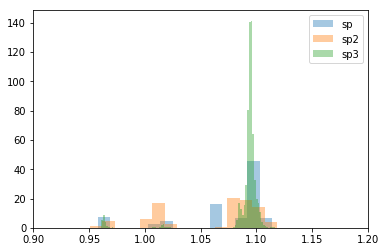

In [328]:
thres_max = 1.2

dist_mask = dist_h < thres_max
bond_mask_temp = np.array(bond_list) == 2
bond_mask = bond_mask_temp[dist_mask]
sns.distplot(dist_h[dist_mask][bond_mask], norm_hist=True, kde=False, label="sp", bins=100)

dist_mask = dist_h < thres_max
bond_mask_temp = np.array(bond_list) == 3
bond_mask = bond_mask_temp[dist_mask]
sns.distplot(dist_h[dist_mask][bond_mask], norm_hist=True, kde=False, label="sp2", bins=100)

dist_mask = dist_h < thres_max
bond_mask_temp = np.array(bond_list) == 4
bond_mask = bond_mask_temp[dist_mask]
sns.distplot(dist_h[dist_mask][bond_mask], norm_hist=True, kde=False, label="sp3", bins=100)

plt.xlim(0.9, thres_max)
plt.legend()

plt.show()

In [329]:
dist_h = np.zeros(0)
bond_list = []

for mol in mols[:1000]:
    dist = get_dist_matrix(df_structures_idx, mol) # [atom, (x,y,z), (atom)]
    c_bond = c_bond_cnt(df_structures_idx, mol)
    mask_c = df_structures_idx.loc[mol].atom.values == 'C'
    mask_h = df_structures_idx.loc[mol].atom.values == 'H'
    if sum(mask_h)*sum(mask_c) > 0:
        dist_c = dist[mask_c]
        for i in range(len(dist_c)):
            dist_h_temp = dist[i, mask_h]
            dist_h = np.hstack([dist_h, dist_h_temp])
            for _ in range(sum(mask_h)):
                bond_list.append(c_bond['c_bond'].values[mask_c][i])
        
bonds = np.array(bond_list)
print(len(bonds))
print(sum(bonds==2))
print(sum(bonds==3))
print(sum(bonds==4))
print(sum(bonds==2)+sum(bonds==3)+sum(bonds==4))

27377
1872
1125
24380
27377


In [315]:
dist_h = np.zeros(0)
bond_list = []
for mol in mols[:1000]:
    dist = get_dist_matrix(df_structures_idx, mol) # [atom, (x,y,z), (atom)]
    c_bond = c_bond_cnt2(df_structures_idx, mol)
    mask_c = df_structures_idx.loc[mol].atom.values == 'C'
    mask_h = df_structures_idx.loc[mol].atom.values == 'H'
    if sum(mask_h)*sum(mask_c) > 0:
        dist_c = dist[mask_c]
        for i in range(len(dist_c)):
            dist_h_temp = dist[i, mask_h]
            dist_h = np.hstack([dist_h, dist_h_temp])
            for _ in range(sum(mask_h)):
                bond_list.append(c_bond['c_bond'].values[mask_c][i])
        
bonds = np.array(bond_list)
print(len(bonds))
print(sum(bonds==2))
print(sum(bonds==3))
print(sum(bonds==4))
print(sum(bonds==2)+sum(bonds==3)+sum(bonds==4))

27377
1948
7439
17990
27377


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


1.6072363342317075
0.9604865434067635


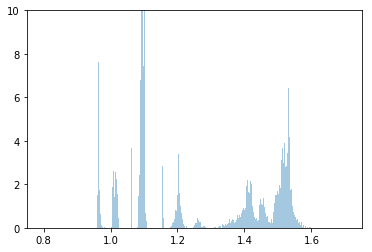

In [303]:
dists = np.zeros(0)

for mol in mols[:20000]:
    dist_arr = get_dist_matrix(df_structures_idx, mol)
    dists = np.hstack([dists, dist_arr[0][dist_arr[0] > 0]])
    
masked = dists[dists < 1.6]
sns.distplot(masked, kde=False, norm_hist=True, bins=1000)
plt.ylim(0,10)
plt.xlim(0.75,1.75)
print(masked.max())
print(masked.min())
plt.show()

In [374]:
cos2_arr = np.zeros(0)
cos3_arr = np.zeros(0)

for mol in mols[:10000]:
    mask = (df_structures_idx.loc[mol]['atom']  == 'C').values
    cos2 = c_cos_cnt(df_structures_idx, mol)[mask]['c_cos2'].values
    cos2_arr = np.hstack([cos2_arr, cos2])
    cos3 = c_cos_cnt(df_structures_idx, mol)[mask]['c_cos3'].values
    cos3_arr = np.hstack([cos3_arr, cos3])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


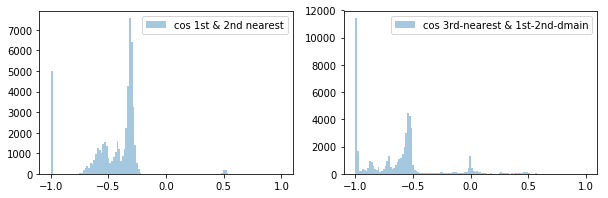

In [418]:
plt.figure(figsize=(10,3))
plt.subplot(121)
sns.distplot(cos2_arr,kde=False, bins=100,  label="cos 1st & 2nd nearest")
plt.xlim(-1.1, 1.1)
plt.legend()

plt.subplot(122)
sns.distplot(cos3_arr,kde=False, bins=200, label="cos 3rd-nearest & 1st-2nd-dmain")
plt.xlim(-1.1, 1.1)
plt.legend()
plt.show()

In [450]:
cos2_arr = np.zeros(0)
cos3_arr = np.zeros(0)

for mol in mols[:10000]:
    mask = (df_structures_idx.loc[mol]['atom']  == 'N').values
    cos2 = n_cos_cnt(df_structures_idx, mol)[mask]['n_cos2'].values
    cos2_arr = np.hstack([cos2_arr, cos2])
    cos3 = n_cos_cnt(df_structures_idx, mol)[mask]['n_cos3'].values
    cos3_arr = np.hstack([cos3_arr, cos3])

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


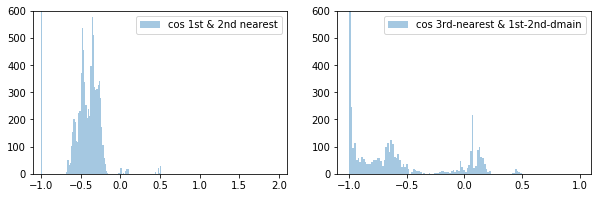

In [453]:
plt.figure(figsize=(10,3))
plt.subplot(121)
sns.distplot(cos2_arr,kde=False, bins=100,  label="cos 1st & 2nd nearest")
plt.ylim(0, 600)
plt.xlim(-1.1, 2.1)
plt.legend()

plt.subplot(122)
sns.distplot(cos3_arr,kde=False, bins=200, label="cos 3rd-nearest & 1st-2nd-dmain")
plt.xlim(-1.1, 1.1)
plt.ylim(0, 600)
plt.legend()
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.


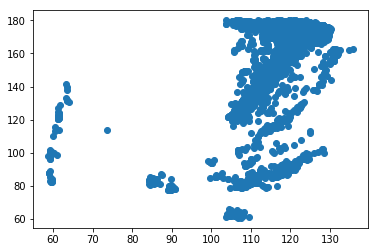

In [454]:
plt.scatter(np.arccos(cos2_arr)/np.pi*180, np.arccos(cos3_arr)/np.pi*180)
plt.show()

In [256]:
# plt.figure(figsize=(15,5))
# plt.subplot(131)
# dist_mask = dist_h < 1.6
# bond_mask_temp = np.array(bond_list) == 2
# bond_mask = bond_mask_temp[dist_mask]
# masked_dir = dir_h[dist_mask][bond_mask]
# plt.scatter(masked_dir[:,0], masked_dir[:,1])

# dist_mask = dist_h < 1.6
# bond_mask_temp = np.array(bond_list) == 3
# bond_mask = bond_mask_temp[dist_mask]
# masked_dir = dir_h[dist_mask][bond_mask]
# plt.scatter(masked_dir[:,0], masked_dir[:,1])



# plt.subplot(132)
# dist_mask = dist_h < 1.6
# bond_mask_temp = np.array(bond_list) == 2
# bond_mask = bond_mask_temp[dist_mask]
# masked_dir = dir_h[dist_mask][bond_mask]
# plt.scatter(masked_dir[:,1], masked_dir[:,2])

# dist_mask = dist_h < 1.6
# bond_mask_temp = np.array(bond_list) == 3
# bond_mask = bond_mask_temp[dist_mask]
# masked_dir = dir_h[dist_mask][bond_mask]
# plt.scatter(masked_dir[:,1], masked_dir[:,2])


# plt.subplot(133)
# dist_mask = dist_h < 1.6
# bond_mask_temp = np.array(bond_list) == 2
# bond_mask = bond_mask_temp[dist_mask]
# masked_dir = dir_h[dist_mask][bond_mask]
# plt.scatter(masked_dir[:,2], masked_dir[:,0])

# dist_mask = dist_h < 1.6
# bond_mask_temp = np.array(bond_list) == 3
# bond_mask = bond_mask_temp[dist_mask]
# masked_dir = dir_h[dist_mask][bond_mask]
# plt.scatter(masked_dir[:,2], masked_dir[:,0])


# plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.


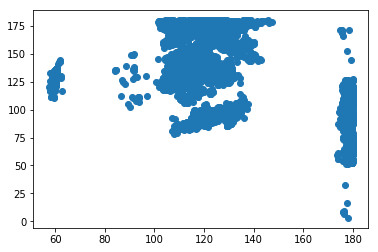

In [379]:
plt.scatter(np.arccos(cos2_arr)/np.pi*180, np.arccos(cos3_arr)/np.pi*180)
plt.show()

In [380]:
c_cos_cnt(df_structures_idx, mol)

,atom,atom_index,c_cos2,c_cos3,molecule_name
0,C,0,-0.329899,-0.565950,dsgdb9nsd_010290
1,O,1,0.000000,0.000000,dsgdb9nsd_010290
2,C,2,-0.372732,-0.555976,dsgdb9nsd_010290
3,C,3,-0.999919,-0.295416,dsgdb9nsd_010290
4,N,4,0.000000,0.000000,dsgdb9nsd_010290
5,C,5,-0.589275,-0.997550,dsgdb9nsd_010290
6,N,6,0.000000,0.000000,dsgdb9nsd_010290
7,O,7,0.000000,0.000000,dsgdb9nsd_010290
8,H,8,0.000000,0.000000,dsgdb9nsd_010290
9,H,9,0.000000,0.000000,dsgdb9nsd_010290


In [382]:
 n_bond_cnt(df_structures_idx, mol)

,atom,atom_index,n_bond,molecule_name
0,C,0,0.0,dsgdb9nsd_010290
1,O,1,0.0,dsgdb9nsd_010290
2,C,2,0.0,dsgdb9nsd_010290
3,C,3,0.0,dsgdb9nsd_010290
4,N,4,1.0,dsgdb9nsd_010290
5,C,5,0.0,dsgdb9nsd_010290
6,N,6,2.0,dsgdb9nsd_010290
7,O,7,0.0,dsgdb9nsd_010290
8,H,8,0.0,dsgdb9nsd_010290
9,H,9,0.0,dsgdb9nsd_010290


In [390]:
n_bonds = np.zeros(0)

for mol in mols[:1000]:
    mask = (df_structures_idx.loc[mol]['atom']  == 'N').values
    nbond =  n_bond_cnt(df_structures_idx, mol)[mask]['n_bond'].values
    n_bonds = np.hstack([n_bonds, nbond])
    
print(len(n_bonds))
print(sum(n_bonds==1))
print(sum(n_bonds==2))
print(sum(n_bonds==3))
print(sum(n_bonds==4))
print(sum(n_bonds==1)+sum(n_bonds==2)+sum(n_bonds==3)+sum(n_bonds==4))

945
363
508
74
0
945


In [416]:
dist_arr = np.zeros(0)
for mol in mols[:10000]:
    dist = get_dist_matrix(df_structures_idx, mol)
    mask = [df_structures_idx.loc[mol]['atom'].values == 'N']
    n_dists = dist[mask]
    if len(n_dists)>0:
        dist_arr = np.hstack([dist_arr, np.sort(n_dists)[0][1:] ])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


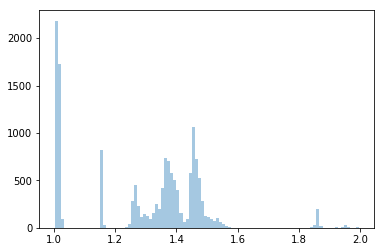

In [417]:
masked = dist_arr[dist_arr < 2]
sns.distplot(masked, kde=False, bins=100)
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


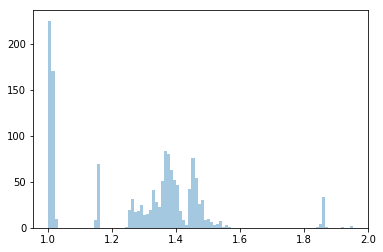

In [415]:
masked = dist_arr[dist_arr < 2]
sns.distplot(masked, kde=False, bins=100)
plt.show()